<a href="https://colab.research.google.com/github/google-ai-edge/mediapipe-samples/blob/main/codelabs/litert_inference/Gemma3_1B_Fine_Tuning_text_to_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemma-3-1B fine-tuning with SFT and on-device deployment with AI Edge Torch and MediaPipe.
This guide walks you through how to fine-tune a Gemma3-1B model using a synthetic dataset and LoRA adaptors followed by conversion to the LiteRT format for mobile deployment. Lastly, we will load the LiteRT model and perform some inference in the colab environment.

Note: to run this colab smoothly you will need a Colab Pro subscription which gives you access to faster GPU instances with more RAM. We recommend using an A100 instance.

# What is Low-Rank Adaptation (LoRA)
This guide demonstrates the use of [Low-Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685), which emerged as a popular method to efficiently fine-tune LLMs as it reduces computational resource requirements while maintaining high performance. With LoRA, the pretrained model weights are frozen. Then trainable adapter layers (LoRA) are attached and only the adapter layers are trained. Afterwards, the adapter weights can be merged with the base model or kept as a separate adapter.

# Prerequisites
* Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/gemma-3-1b-pt) by clicking on the Agree and access repository button on the model page at: http://huggingface.co/google/gemma-3-1b-pt.
* Create a HuggingFace Finegrained access token with the following permissions (you will push your model to the Hub during training):
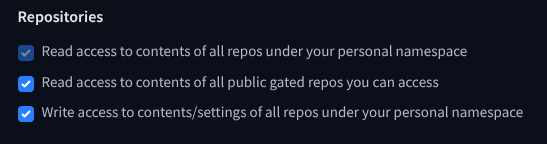

* Open Colab Secrets: In your Google Colab notebook, locate the Secrets (key) icon in the left-hand sidebar and click on it.

* Add a new secret: Click the `Add Secret` button.

* Name your secret: Enter `HF_TOKEN` for your token in the `Name` field.

* Paste your token: In the `Value` field, paste the actual token you want to store.

Note: When running notebooks in this repository with Google Colab, some users may see the following warning message:

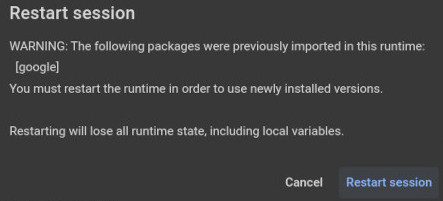

Please click `Restart Session` and run the next cell (do not run the pip install cell a second time).

In [ ]:
# Install Pytorch & other libraries
%pip install --upgrade "torch==2.6.0" \
  "transformers>=4.51.3" \
  "datasets==3.3.2" \
  "accelerate==1.4.0" \
  "evaluate==0.4.3" \
  "trl==0.15.2" \
  "peft==0.14.0" \
  protobuf \
  sentencepiece \
  "flash-attn==2.7.4.post1" \
  ai-edge-torch-nightly==0.6.0.dev20250523 \
  ai-edge-litert==1.3.0 \
  mediapipe==0.10.21

In [ ]:
import os
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
login(hf_token)

# For the purposes of this demonstration we disable W&B integration.
# See https://huggingface.co/docs/transformers/main_classes/callback#transformers.integrations.WandbCallback for details.
os.environ["WANDB_DISABLED"] = "true"

# Create and prepare the fine-tuning dataset
When fine-tuning LLMs, it is important to know your use case and the task you want to solve. This helps you create a dataset to fine-tune your model. If you haven't defined your use case yet, you might want to go back to the drawing board.

As an example, this guide focuses on the following use case:
* Fine-tune a natural language to SQL model for seamless integration into a data analysis tool. The objective is to significantly reduce the time and expertise required for SQL query generation, enabling even non-technical users to extract meaningful insights from data.

Text-to-SQL can be a good use case for fine-tuning LLMs, as it is a complex task that requires a lot of (internal) knowledge about the data and the SQL language.

Once you have determined that fine-tuning is the right solution, you need a dataset to fine-tune. The dataset should be a diverse set of demonstrations of the task(s) you want to solve. There are several ways to create such a dataset, including:

* Using existing open-source datasets, such as [Spider](https://huggingface.co/datasets/spider).
* Using synthetic datasets created by LLMs, such as [Alpaca](https://huggingface.co/datasets/tatsu-lab/alpaca).
* Using datasets created by humans, such as [Dolly](https://huggingface.co/datasets/databricks/databricks-dolly-15k).
* Using a combination of the methods, such as [Orca](https://huggingface.co/datasets/Open-Orca/OpenOrca).

Each of the methods has its own advantages and disadvantages and depends on the budget, time, and quality requirements. For example, using an existing dataset is the easiest but might not be tailored to your specific use case, while using domain experts might be the most accurate but can be time-consuming and expensive. It is also possible to combine several methods to create an instruction dataset, as shown in [Orca: Progressive Learning from Complex Explanation Traces of GPT-4](https://arxiv.org/abs/2306.02707).

This guide uses an already existing dataset ([philschmid/gretel-synthetic-text-to-sql](https://huggingface.co/datasets/philschmid/gretel-synthetic-text-to-sql)), a high quality synthetic Text-to-SQL dataset including natural language instructions, schema definitions, reasoning and the corresponding SQL query.

[Hugging Face TRL](https://huggingface.co/docs/trl/en/index) supports automatic templating of conversation dataset formats. This means you only need to convert your dataset into the right json objects, and trl takes care of templating and putting it into the right format.

```json
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
```

The [philschmid/gretel-synthetic-text-to-sql](https://huggingface.co/datasets/philschmid/gretel-synthetic-text-to-sql) contains over 100k samples. To keep the guide small, it is downsampled to only use 10,000 samples.

You can now use the Hugging Face Datasets library to load the dataset and create a prompt template to combine the natural language instruction, schema definition and add a system message for your assistant.

In [ ]:
from datasets import load_dataset

# System message for the assistant
system_message = """You are a text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA."""

# User prompt that combines the user query and the schema
user_prompt = """Given the <USER_QUERY> and the <SCHEMA>, generate the corresponding SQL command to retrieve the desired data, considering the query's syntax, semantics, and schema constraints.

<SCHEMA>
{context}
</SCHEMA>

<USER_QUERY>
{question}
</USER_QUERY>
"""
def create_conversation(sample):
  return {
    "messages": [
      # {"role": "system", "content": system_message},
      {"role": "user", "content": user_prompt.format(question=sample["sql_prompt"], context=sample["sql_context"])},
      {"role": "assistant", "content": sample["sql"]}
    ]
  }

# Load dataset from the hub
dataset = load_dataset("philschmid/gretel-synthetic-text-to-sql", split="train")
dataset = dataset.shuffle().select(range(12500))

# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

# Print formatted user prompt
print(dataset["train"][345]["messages"][1]["content"])

# Fine-tune Gemma using TRL and the SFTTrainer
You are now ready to fine-tune your model. Hugging Face TRL [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) (Supervised Fine-Tuning Trainer) makes it straightforward to supervise fine-tune open LLMs. The SFTTrainer is a subclass of the Trainer from the transformers library and supports all the same features, including logging, evaluation, and checkpointing, but adds additional quality of life features, including:

* Dataset formatting, including conversational and instruction formats
* Training on completions only, ignoring prompts
* Packing datasets for more efficient training
* Parameter-efficient fine-tuning (PEFT) support including LoRA
* Preparing the model and tokenizer for conversational fine-tuning (such as adding special tokens)

The following code loads the Gemma model and tokenizer from Hugging Face.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForImageTextToText

# Hugging Face model id
model_id = "google/gemma-3-1b-pt" # or `google/gemma-3-4b-pt`, `google/gemma-3-12b-pt`, `google/gemma-3-27b-pt`

# Select model class based on id
if model_id == "google/gemma-3-1b-pt":
    model_class = AutoModelForCausalLM
else:
    model_class = AutoModelForImageTextToText

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] >= 8:
    torch_dtype = torch.bfloat16
else:
    torch_dtype = torch.float16

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch_dtype, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

# Load model and tokenizer
model = model_class.from_pretrained(model_id, **model_kwargs, token=hf_token)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it", token=hf_token) # Load the Instruction Tokenizer to use the official Gemma template

The `SFTTrainer` supports a native integration with `peft`, which makes it straightforward to efficiently tune LLMs using LoRA. You only need to create a `LoraConfig` and provide it to the trainer.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"] # make sure to save the lm_head and embed_tokens as you train the special tokens
)

Before you can start your training, you need to define the hyperparameter you want to use in a `SFTConfig` instance.

In [ ]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="gemma-text-to-sql",         # directory to save and repository id
    max_seq_length=512,                     # max sequence length for model and packing of the dataset
    packing=True,                           # Groups multiple samples in the dataset into a single sequence
    # For real use-cases, you will want to train your model with epochs rather than a small number of steps
    num_train_epochs=3,                    # number of training epochs
    #max_steps=100,
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on HF blog post
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,   # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on HF blog post
    warmup_ratio=0.03,                      # warmup ratio based on HF blog post
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [ ]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    processing_class=tokenizer
)

Start training by calling the `train()` method.

In [ ]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

Before you can test your model, make sure to free the memory.

In [ ]:
# free the memory
del model
del trainer
torch.cuda.empty_cache()

When using LoRA, you only train adapters and not the full model. This means when saving the model during training you only save the adapter weights and not the full model. If you want to save the full model, which makes it easier to use with serving stacks like vLLM or TGI, you can merge the adapter weights into the model weights using the `merge_and_unload` method and then save the model with the `save_pretrained` method. This saves a default model, which can be used for inference.

In [ ]:
from peft import PeftModel

# Load Model base model
model = model_class.from_pretrained(model_id, low_cpu_mem_usage=True)

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, args.output_dir)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained("merged_model", safe_serialization=True, max_shard_size="2GB")

processor = AutoTokenizer.from_pretrained(args.output_dir)
processor.save_pretrained("merged_model")

# Test Model Inference and generate SQL queries
After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.

In [ ]:
import torch
from transformers import pipeline

model_id = "gemma-text-to-sql"

# Load Model with PEFT adapter
model = model_class.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch_dtype,
  attn_implementation="eager",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's load a random sample from the test dataset and generate a SQL command.

In [ ]:
import random
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
random.seed(1337)
rand_idx = random.randint(0, len(dataset["test"]))
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
stop_token_ids = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<end_of_turn>")]
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)

# Generate our SQL query.
outputs = pipe(prompt, max_new_tokens=256, do_sample=False, temperature=0.1, top_k=50, top_p=0.1, eos_token_id=stop_token_ids, disable_compile=True)

# Extract the user query and original answer
print("======================================================================")
print("Prompt:")
print(f"  Context:\n   ", re.search(r'<SCHEMA>\n(.*?)\n</SCHEMA>', test_sample['messages'][0]['content'], re.DOTALL).group(1).strip())
print(f"  Query:\n   ", re.search(r'<USER_QUERY>\n(.*?)\n</USER_QUERY>', test_sample['messages'][0]['content'], re.DOTALL).group(1).strip())
print("======================================================================")
print(f"Original Answer:\n  {test_sample['messages'][1]['content']}")
print("======================================================================")
print(f"Generated Answer:\n  {outputs[0]['generated_text'][len(prompt):]}")

# Load up the checkpoint in AI Edge Torch and convert to LiteRT.
Now let's convert our model (including 8-bit quantization) to LiteRT format, this will take roughly 10+ minutes to finish. The output tflite will be saved in the `/content` subfolder, with the name `gemma3_1b_finetune_q8_ekv1024.tflite`.

In [ ]:
import torch

from ai_edge_torch.generative.examples.gemma3 import gemma3
from ai_edge_torch.generative.layers import kv_cache
from ai_edge_torch.generative.utilities import converter
from ai_edge_torch.generative.utilities.export_config import ExportConfig


PREFILL_SEQ_LENS = [512]
KV_CACHE_MAX_LEN = 1024

def _create_mask(mask_len, kv_cache_max_len):
  mask = torch.full(
      (mask_len, kv_cache_max_len), float('-inf'), dtype=torch.float32
  )
  mask = torch.triu(mask, diagonal=1).unsqueeze(0).unsqueeze(0)
  return mask


def _create_export_config(
    prefill_seq_lens: list[int], kv_cache_max_len: int
) -> ExportConfig:
  """Creates the export config for the model."""
  export_config = ExportConfig()
  if isinstance(prefill_seq_lens, list):
    prefill_mask = [_create_mask(i, kv_cache_max_len) for i in prefill_seq_lens]
  else:
    prefill_mask = _create_mask(prefill_seq_lens, kv_cache_max_len)

  export_config.prefill_mask = prefill_mask

  decode_mask = torch.full(
      (1, kv_cache_max_len), float('-inf'), dtype=torch.float32
  )
  decode_mask = torch.triu(decode_mask, diagonal=1).unsqueeze(0).unsqueeze(0)
  export_config.decode_mask = decode_mask
  export_config.kvcache_layout = kv_cache.KV_LAYOUT_TRANSPOSED
  export_config.mask_as_input = True
  return export_config


def convert_to_litert():
  with torch.inference_mode(True):
    pytorch_model = gemma3.build_model_1b(
      "/content/merged_model", kv_cache_max_len=KV_CACHE_MAX_LEN,
    )
    converter.convert_to_tflite(
        pytorch_model,
        output_path="/content/",
        output_name_prefix="gemma3_1b_finetune",
        prefill_seq_len=PREFILL_SEQ_LENS,
        quantize=converter.QuantizationName.DYNAMIC_INT8,
        lora_ranks=None,
        export_config=_create_export_config(
            prefill_seq_lens=PREFILL_SEQ_LENS,
            kv_cache_max_len=KV_CACHE_MAX_LEN,
        ),
    )

# Run model conversion.
convert_to_litert()

In [ ]:
from ai_edge_litert import interpreter as interpreter_lib
from transformers import AutoTokenizer
import numpy as np
from collections.abc import Sequence
import sys

In [ ]:
from transformers import AutoTokenizer

model_id = 'google/gemma-3-1b-pt'
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

In [ ]:
interpreter = interpreter_lib.InterpreterWithCustomOps(
    custom_op_registerers=["pywrap_genai_ops.GenAIOpsRegisterer"],
    model_path="/content/gemma3_1b_finetune_q8_ekv1024.tflite", # supported on both CPU and GPU on Android
    num_threads=2,
    experimental_default_delegate_latest_features=True)

# Create pipeline with LiteRT models

In [ ]:
def _get_mask(shape: Sequence[int], k: int):
  """Gets the mask for the input to the model.

  Args:
    shape: The shape of the mask input to the model.
    k: all elements below the k-th diagonal are set to 0.

  Returns:
    The mask for the input to the model. All the elements in the mask are set
    to -inf except that all the elements below the k-th diagonal are set to 0.
  """
  mask = np.ones(shape, dtype=np.float32) * float("-inf")
  mask = np.triu(mask, k=k)
  return mask

class LiteRTLlmPipeline:

  def __init__(self, interpreter, tokenizer):
    """Initializes the pipeline."""
    self._interpreter = interpreter
    self._tokenizer = tokenizer

    self._prefill_runner = None
    self._decode_runner = self._interpreter.get_signature_runner("decode")


  def _init_prefill_runner(self, num_input_tokens: int):
    """Initializes all the variables related to the prefill runner.

    This method initializes the following variables:
      - self._prefill_runner: The prefill runner based on the input size.
      - self._max_seq_len: The maximum sequence length supported by the model.

    Args:
      num_input_tokens: The number of input tokens.
    """
    if not self._interpreter:
      raise ValueError("Interpreter is not initialized.")

    # Prefill runner related variables will be initialized in `predict_text` and
    # `compute_log_likelihood`.
    self._prefill_runner = self._get_prefill_runner(num_input_tokens)
    # input_token_shape has shape (batch, max_seq_len)
    input_token_shape = self._prefill_runner.get_input_details()["tokens"][
        "shape"
    ]
    if len(input_token_shape) == 1:
      self._max_seq_len = input_token_shape[0]
    else:
      self._max_seq_len = input_token_shape[1]

    # kv cache input has shape [batch=1, num_kv_heads, cache_size, head_dim].
    kv_cache_shape = self._prefill_runner.get_input_details()["kv_cache_k_0"][
        "shape"
    ]
    self._max_kv_cache_seq_len = kv_cache_shape[2]

  def _init_kv_cache(self) -> dict[str, np.ndarray]:
    if self._prefill_runner is None:
      raise ValueError("Prefill runner is not initialized.")
    kv_cache = {}
    for input_key in self._prefill_runner.get_input_details().keys():
      if "kv_cache" in input_key:
        kv_cache[input_key] = np.zeros(
            self._prefill_runner.get_input_details()[input_key]["shape"],
            dtype=np.float32,
        )
        kv_cache[input_key] = np.zeros(
            self._prefill_runner.get_input_details()[input_key]["shape"],
            dtype=np.float32,
        )
    return kv_cache

  def _get_prefill_runner(self, num_input_tokens: int) :
    """Gets the prefill runner with the best suitable input size.

    Args:
      num_input_tokens: The number of input tokens.

    Returns:
      The prefill runner with the smallest input size.
    """
    best_signature = None
    delta = sys.maxsize
    max_prefill_len = -1
    for key in self._interpreter.get_signature_list().keys():
      if "prefill" not in key:
        continue
      input_pos = self._interpreter.get_signature_runner(key).get_input_details()[
          "input_pos"
      ]
      # input_pos["shape"] has shape (max_seq_len, )
      seq_size = input_pos["shape"][0]
      max_prefill_len = max(max_prefill_len, seq_size)
      if num_input_tokens <= seq_size and seq_size - num_input_tokens < delta:
        delta = seq_size - num_input_tokens
        best_signature = key
    if best_signature is None:
      raise ValueError(
          "The largest prefill length supported is %d, but we have %d number of input tokens"
          %(max_prefill_len, num_input_tokens)
      )
    return self._interpreter.get_signature_runner(best_signature)

  def _run_prefill(
      self, prefill_token_ids: Sequence[int],
  ) -> dict[str, np.ndarray]:
    """Runs prefill and returns the kv cache.

    Args:
      prefill_token_ids: The token ids of the prefill input.

    Returns:
      The updated kv cache.
    """
    if not self._prefill_runner:
      raise ValueError("Prefill runner is not initialized.")
    prefill_token_length = len(prefill_token_ids)
    if prefill_token_length == 0:
      return self._init_kv_cache()

    # Prepare the input to be [1, max_seq_len].
    input_token_ids = [0] * self._max_seq_len
    input_token_ids[:prefill_token_length] = prefill_token_ids
    input_token_ids = np.asarray(input_token_ids, dtype=np.int32)
    input_token_ids = np.expand_dims(input_token_ids, axis=0)

    # Prepare the input position to be [max_seq_len].
    input_pos = [0] * self._max_seq_len
    input_pos[:prefill_token_length] = range(prefill_token_length)
    input_pos = np.asarray(input_pos, dtype=np.int32)

    # Initialize kv cache.
    prefill_inputs = self._init_kv_cache()
    # Prepare the tokens and input position inputs.
    prefill_inputs.update({
        "tokens": input_token_ids,
        "input_pos": input_pos,
    })
    if "mask" in self._prefill_runner.get_input_details().keys():
      # For prefill, mask has shape [batch=1, 1, seq_len, kv_cache_size].
      # We want mask[0, 0, i, j] = 0 for j<=i and -inf otherwise.
      prefill_inputs["mask"] = _get_mask(
          shape=self._prefill_runner.get_input_details()["mask"]["shape"],
          k=1,
      )
    prefill_outputs = self._prefill_runner(**prefill_inputs)
    if "logits" in prefill_outputs:
      # Prefill outputs includes logits and kv cache. We only output kv cache.
      prefill_outputs.pop("logits")

    return prefill_outputs

  def _greedy_sampler(self, logits: np.ndarray) -> int:
    return int(np.argmax(logits))


  def _run_decode(
      self,
      start_pos: int,
      start_token_id: int,
      kv_cache: dict[str, np.ndarray],
      max_decode_steps: int,
  ) -> str:
    """Runs decode and outputs the token ids from greedy sampler.

    Args:
      start_pos: The position of the first token of the decode input.
      start_token_id: The token id of the first token of the decode input.
      kv_cache: The kv cache from the prefill.
      max_decode_steps: The max decode steps.

    Returns:
      The token ids from the greedy sampler.
    """
    next_pos = start_pos
    next_token = start_token_id
    decode_text = []
    decode_inputs = kv_cache

    for _ in range(max_decode_steps):
      decode_inputs.update({
          "tokens": np.array([[next_token]], dtype=np.int32),
          "input_pos": np.array([next_pos], dtype=np.int32),
      })
      if "mask" in self._decode_runner.get_input_details().keys():
        # For decode, mask has shape [batch=1, 1, 1, kv_cache_size].
        # We want mask[0, 0, 0, j] = 0 for j<=next_pos and -inf otherwise.
        decode_inputs["mask"] = _get_mask(
            shape=self._decode_runner.get_input_details()["mask"]["shape"],
            k=next_pos + 1,
        )
      decode_outputs = self._decode_runner(**decode_inputs)
      # Output logits has shape (batch=1, 1, vocab_size). We only take the first
      # element.
      logits = decode_outputs.pop("logits")[0][0]
      next_token = self._greedy_sampler(logits)
      if next_token == self._tokenizer.eos_token_id:
        break
      decode_text.append(self._tokenizer.decode(next_token, skip_special_tokens=True))
      if len(decode_text[-1]) == 0:
        # Break out the loop if we hit the special token.
        break

      print(decode_text[-1], end='', flush=True)
      # Decode outputs includes logits and kv cache. We already poped out
      # logits, so the rest is kv cache. We pass the updated kv cache as input
      # to the next decode step.
      decode_inputs = decode_outputs
      next_pos += 1

    print() # print a new line at the end.
    return ''.join(decode_text)

  def generate(self, prompt: str, max_decode_steps: int | None = None) -> str:
    messages=[{ 'role': 'user', 'content': prompt}]
    token_ids = self._tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
    # Initialize the prefill runner with the suitable input size.
    self._init_prefill_runner(len(token_ids))

    # Run prefill.
    # Prefill up to the seond to the last token of the prompt, because the last
    # token of the prompt will be used to bootstrap decode.
    prefill_token_length = len(token_ids) - 1

    print('Running prefill')
    kv_cache = self._run_prefill(token_ids[:prefill_token_length])
    # Run decode.
    print('Running decode')
    actual_max_decode_steps = self._max_kv_cache_seq_len - prefill_token_length - 1
    if max_decode_steps is not None:
      actual_max_decode_steps = min(actual_max_decode_steps, max_decode_steps)
    decode_text = self._run_decode(
        prefill_token_length,
        token_ids[prefill_token_length],
        kv_cache,
        actual_max_decode_steps,
    )
    return decode_text

# Generate text from the converted model

In [ ]:
# Disclaimer: Model performance demonstrated with the Python API in this notebook is not representative of performance on a local device.
pipeline = LiteRTLlmPipeline(interpreter, tokenizer)

In [ ]:
output = pipeline.generate(prompt, max_decode_steps = 256)

# Prepare task bundle for MediaPipe deployment
The task file will be named as `gemma3_1b_it_q8_ekv1024.task`, and placed under the `/content` directory. Please refer to https://ai.google.dev/edge/mediapipe/solutions/genai/llm_inference about how to deploy the task file with MediaPipe LLM inference example.

In [ ]:
from huggingface_hub import hf_hub_download
import joblib

REPO_ID = "google/gemma-3-1b-it"
FILENAME = "tokenizer.model"

tokenizer_model = (
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME, local_dir="/content", token=hf_token)
)

In [ ]:
from mediapipe.tasks.python.genai.bundler import llm_bundler

def build_task_bundle():
  output_file = "/content/gemma3_1b_finetune_q8_ekv1024.task"
  tflite_model = "/content/gemma3_1b_finetune_q8_ekv1024.tflite"
  tokenizer_model = (
      "/content/tokenizer.model"
  )
  config = llm_bundler.BundleConfig(
      tflite_model=tflite_model,
      tokenizer_model=tokenizer_model,
      start_token="<bos>",
      stop_tokens=["<eos>", "<end_of_turn>"],
      output_filename=output_file,
      enable_bytes_to_unicode_mapping=False,
      prompt_prefix="<start_of_turn>user\n",
      prompt_suffix="<end_of_turn>\n<start_of_turn>model\n",
  )
  llm_bundler.create_bundle(config)

# Build the MediaPipe task bundle.
build_task_bundle()

# Try it out with AI Edge Gallery

* Download and install the [apk](https://github.com/google-ai-edge/gallery/releases/latest/download/ai-edge-gallery.apk).
* Follow the instructions in the app. If you upload the MediaPipe task bundle in the following step then it's easy to load that into Gallery to test out.

In [ ]:
# Copy MediaPipe task bundle to Google Drive.
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy("gemma3_1b_finetune_q8_ekv1024.task","/content/drive/MyDrive/")

# Integration with your mobile application
Check out our MediaPipe LLM Inference API [guide](https://ai.google.dev/edge/mediapipe/solutions/genai/llm_inference) on how to integrate your model into your Android, iOS, or Web application!